In [1]:
 import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## for distances
from scipy.spatial.distance import cosine

In [2]:
# Set pandas formatting options
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 500)

In [3]:
# Set up wikidata API
!pip -q install qwikidata
!pip -q install sparqlwrapper

from qwikidata.entity import WikidataItem, WikidataLexeme, WikidataProperty
from qwikidata.linked_data_interface import get_entity_dict_from_api
import sys
import seaborn as sns
import folium # mapping
from folium.plugins import HeatMap
import missingno as msno
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt
from typing import List, Dict

import warnings
warnings.filterwarnings('ignore')
print("Setup Complete")

ModuleNotFoundError: No module named 'folium'

In [22]:
# modified from https://itnext.io/extracting-data-from-wikidata-using-sparql-and-python-59e0037996f
import json
import ast

class WikiDataQueryResults:
    """
    A class that can be used to query data from Wikidata using SPARQL and return the results as a Pandas DataFrame or a list
    of values for a specific key.
    """
    def __init__(self, query: str):
        """
        Initializes the WikiDataQueryResults object with a SPARQL query string.
        :param query: A SPARQL query string.
        """
        self.user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
        self.endpoint_url = "https://query.wikidata.org/sparql"
        self.sparql = SPARQLWrapper(self.endpoint_url, agent=self.user_agent)
        self.sparql.setQuery(query)
        self.sparql.setReturnFormat(JSON)

    def __transform2dicts(self, results: List[Dict]) -> List[Dict]:
        """
        Helper function to transform SPARQL query results into a list of dictionaries.
        :param results: A list of query results returned by SPARQLWrapper.
        :return: A list of dictionaries, where each dictionary represents a result row and has keys corresponding to the
        variables in the SPARQL SELECT clause.
        """
        new_results = []
        for result in results:
            print(result)
            break
            new_result = {}
            for key in result:
                new_result[key] = result[key]['value']
            new_results.append(new_result)
        return new_results

    # Function to remove invalid control characters
    def __remove_invalid_chars(text):
        return ''.join(char for char in text if ord(char) > 31 or char == '\n' or char == '\t')

    def _load(self) -> List[Dict]:
        """
        Helper function that loads the data from Wikidata using the SPARQLWrapper library, and transforms the results into
        a list of dictionaries.
        :return: A list of dictionaries, where each dictionary represents a result row and has keys corresponding to the
        variables in the SPARQL SELECT clause.
        """
        results = self.sparql.queryAndConvert()['results']['bindings']
        # Preprocess the JSON response to remove control characters
        results = json.dumps(results).encode('utf-8').decode('unicode_escape')

        return results

    def load_as_dataframe(self) -> pd.DataFrame:
        """
        Executes the SPARQL query and returns the results as a Pandas DataFrame.
        :return: A Pandas DataFrame representing the query results.
        """
        results = self._load()
        df = pd.read_json(results)
        df = df.applymap(lambda x: x['value'])
        return df

# Q1



## (a)

In [23]:
# Some relations such as wdt:P1081 links to multiple values,
# Fortunately, calling ?country wdt:P1081 ?HDI will automatically return the latest HDI,

countryQuery = """
SELECT
  ?countryLabel
  ?lifeExpectancy
  ?medianIncome
  ?HDI
  ?retirementAge
  ?unemploymentRate
WHERE {
  ?country wdt:P31 wd:Q6256;  #Instance of a country
    wdt:P2250 ?lifeExpectancy; #Life Expectancy
    wdt:P3529 ?medianIncome;  # median Income
    wdt:P1081 ?HDI;  # Human Development Index (automatically provides the latest value)
    wdt:P3001  ?retirementAge; #Retirement Age
    wdt:P1198 ?unemploymentRate; # Unemployment Rate

  # This line will map the country (PIDs) to their labels countryLabel (actual names), in your choice of language
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }

  ### YOUR CODE ENDS HERE
}
"""
# don't need two wdt and wt, just one is good (keep the p one)
## Output format is given below
Country_df = WikiDataQueryResults(countryQuery).load_as_dataframe()
Country_df

,medianIncome,retirementAge,unemploymentRate,lifeExpectancy,HDI,countryLabel
0,70336,65,7,83.62,0.936,Canada
1,34822,60,4,83.98488,0.925,Japan
2,557655,60,4,83.98488,0.925,Japan
3,51489,67,3,82.50976,0.966,Norway
4,21959,65,16,78.71707,0.905,Spain
5,21959,65,16,78.96585,0.905,Spain
6,21959,65,16,79.36829,0.905,Spain
7,21959,65,16,79.56829,0.905,Spain
8,21959,65,16,79.61951,0.905,Spain
9,21959,65,16,79.87073,0.905,Spain


## (b)

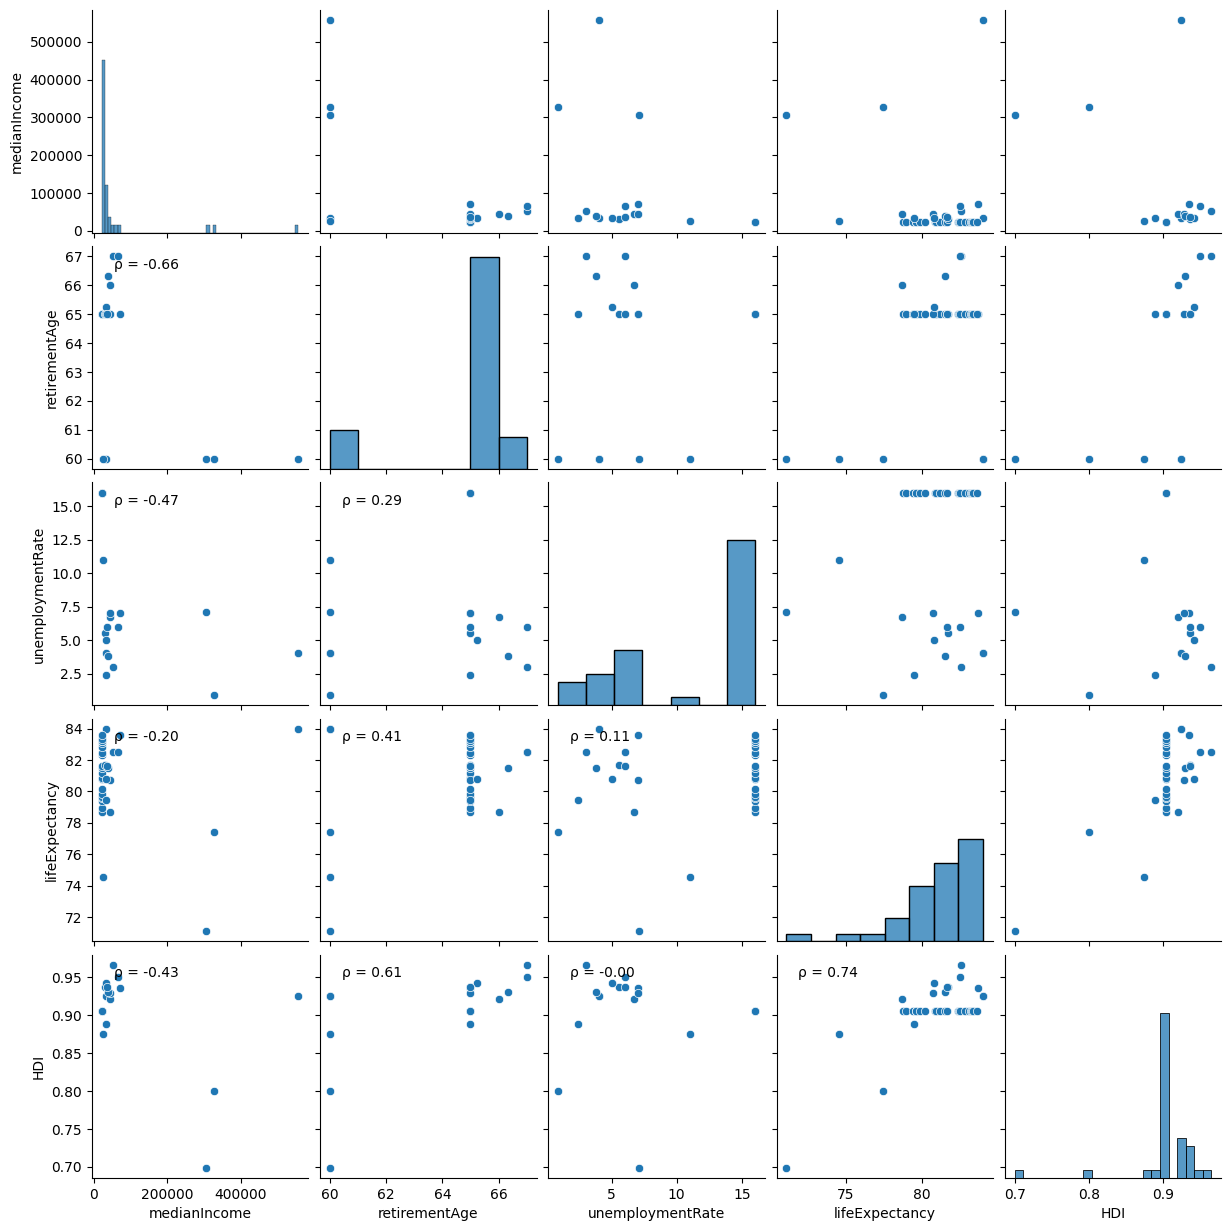

In [24]:
from scipy.stats import pearsonr

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

# get everything to numerical
Country_df=Country_df.drop(columns=['countryLabel'])
Country_df = Country_df.apply(pd.to_numeric)

# pairplot
## YOUR CODE STARTS HERE
g=sns.pairplot(Country_df)

# seaborn's pair plot function
## YOUR CODE ENDS HERE
g.map_lower(corrfunc)
plt.show()

## (c)

**Enter answer here:** Reflecting on the correlation scores from Q1(b), provide a short commentary on which two country properties show the strongest correlation and discuss possible reasons for this high
correlation.

The two country properties showing the highest correlation properties are life expectancy and HDI. Some reasons for this might because countries that prioritize investments in healthcare, education, and economic development are likely to experience higher life expectancies among the people living in they countries. So a High Development Index correlates to a higher life expectancies.


# Q2

## (a)

In [25]:
actor_genre_Query = """
SELECT DISTINCT ?movieLabel ?actorLabel ?genreLabel
WHERE {
  ## YOUR CODE STARTS HERE

  ?movie wdt:P31 wd:Q11424;          # Instance of a film
         wdt:P161 ?actor;            # Actor
         wdt:P136 ?genre;            #genre
         #wdt:P166 wd:Q103618;
         wdt:P577 ?releaseDate.     # Release date of the movie

  ?actor wdt:P166 wd:Q103618.        # Actress award received by the actor

  FILTER(YEAR(?releaseDate) > 1995 && YEAR(?releaseDate) < 2023)  # Release date between 1995 and 2023 exclusive

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
limit 2000
"""

## Output format is given below
actor_genre_df = WikiDataQueryResults(actor_genre_Query).load_as_dataframe()

actor_genre_df

,movieLabel,actorLabel,genreLabel
0,Hope Springs,Meryl Streep,drama film
1,Hope Springs,Meryl Streep,romantic comedy
2,Adaptation,Meryl Streep,comedy film
3,The Iron Lady,Meryl Streep,biographical film
4,The Iron Lady,Meryl Streep,drama film
...,...,...,...
1995,The Pulitzer at 100,Natalie Portman,documentary film
1996,Annihilation,Natalie Portman,science fiction film
1997,Avengers: Endgame,Natalie Portman,adventure film
1998,Avengers: Endgame,Natalie Portman,action film


## (b)

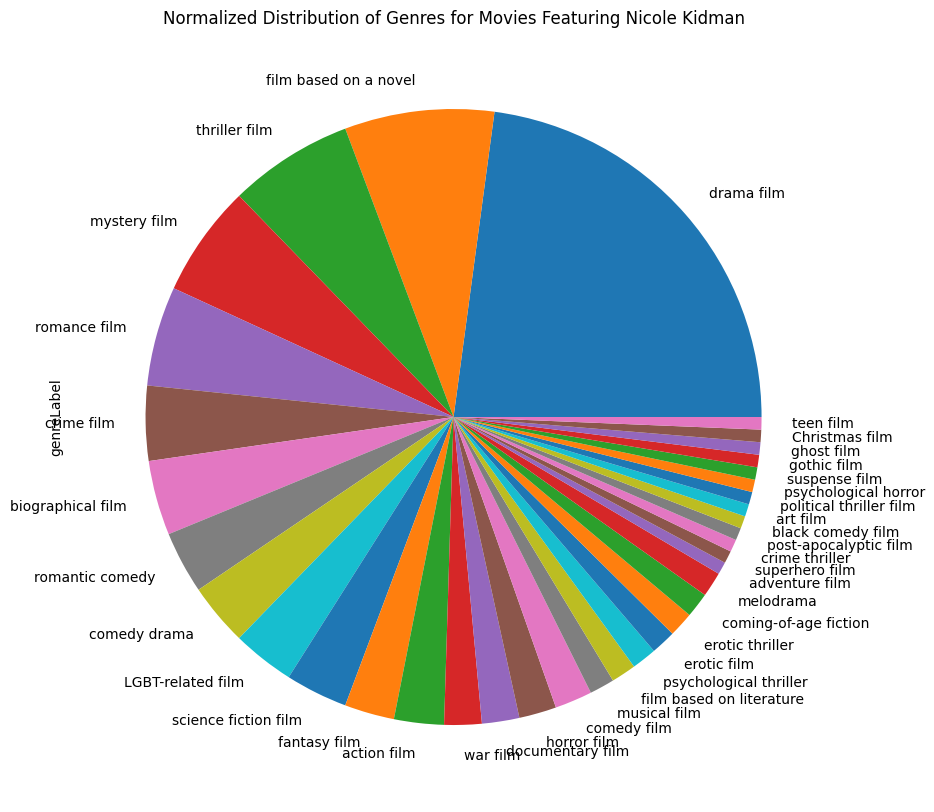

In [26]:
## YOUR CODE STARTS HERE
actor_genre_matrix = pd.pivot_table(actor_genre_df, index='actorLabel', columns='genreLabel', aggfunc='size', fill_value=0)

actor_genre_matrix_sorted_index = actor_genre_matrix.sort_index(ascending = True)
# Sort the sorted actor-genre matrix DataFrame by columns (genreLabel)
actor_genre_matrix_sorted = actor_genre_matrix_sorted_index.sort_index(axis=1, ascending = True)


# Nicole Kidman Dataframe
nicole_kidman_movies = actor_genre_df[actor_genre_df['actorLabel'] == 'Nicole Kidman']

# normalized distribution of genres for movies featuring Nicole Kidman
genre_counts = nicole_kidman_movies['genreLabel'].value_counts()
actor_normalized_genre_vector = genre_counts / genre_counts.sum()

# Plot the pie chart
actor_normalized_genre_vector.plot(kind='pie', figsize=(10,10))
plt.title('Normalized Distribution of Genres for Movies Featuring Nicole Kidman')
plt.show()

## (c)

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

# Output should be a dataframe with columns "Actor1", "Actor2", "Cosine Similarity",
# Print Top 15, sorted by "Cosine Similarity", then "Actor1", then "Actor2" all in Descending Order

# Initialize an empty list to store the results
similarity_results = []
# hint, similarity_results = [ (actors1, actors2, cosine_similarity_score), ... ]

## YOUR CODE STARTS HERE

# cosine similarity matrix between actor vectors that come from the actor_genre matrix
cos_sim_matrix = cosine_similarity(actor_genre_matrix_sorted)

# names of actors as vectors
actors = actor_genre_matrix_sorted.index.tolist()


# Compute the similarity between actors based on the cosine similarity score of these vectors
for i in range(len(actors)):
    for j in range(i + 1, len(actors)):
        actor1 = actors[i]
        actor2 = actors[j]
        cos_sim = cos_sim_matrix[i, j]
        similarity_results.append((actor1, actor2, cos_sim))
## YOUR CODE ENDS HERE
## Output format is given below

# Create a DataFrame for the results
similarity_df = pd.DataFrame(similarity_results, columns=['Actor1', 'Actor2', 'Cosine Similarity'])

# Sort the DataFrame
sorted_similarity_df = similarity_df.sort_values(by=['Cosine Similarity', 'Actor1', 'Actor2'], ascending=False)

# Display the sorted DataFrame
sorted_similarity_df.head(15)

,Actor1,Actor2,Cosine Similarity
233,Elizabeth Taylor,Simone Signoret,1.000000
30,Anna Magnani,Simone Signoret,1.000000
6,Anna Magnani,Elizabeth Taylor,1.000000
502,Kathy Bates,Renée Zellweger,0.947374
450,Julianne Moore,Nicole Kidman,0.937813
532,Marion Cotillard,Susan Sarandon,0.936910
176,Charlize Theron,Natalie Portman,0.932163
381,Helen Mirren,Marion Cotillard,0.930045
526,Marion Cotillard,Natalie Portman,0.929228
525,Marion Cotillard,Meryl Streep,0.928390
